### Details for code ordinances found at https://library.municode.com/az/scottsdale/codes/code_of_ordinances


In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
code_violations_query = ''' select * from [City_of_Scottsdale].[dbo].[np_CodeViolations] '''

code_violations = pd.read_sql(code_violations_query, connection)
connection.close()

# convert latitude and longitude attributes to numeric from object
# can I combine both of the below lines of code into one?
code_violations['_Latitude_'] = pd.to_numeric(code_violations['_Latitude_'], errors="coerce")
code_violations['_Longitude_'] = pd.to_numeric(code_violations['_Longitude_'], errors="coerce")

# convert date fields from object to datetime format to be able to perform math below
code_violations['_DateComplaintReceived_'] = pd.to_datetime(code_violations['_DateComplaintReceived_'])
code_violations['_DateComplaintClosed_'] = pd.to_datetime(code_violations['_DateComplaintClosed_'])

# find difference between date complaint was received and when it was closed
code_violations['Open_Close_Dif'] = code_violations['_DateComplaintClosed_'] - code_violations['_DateComplaintReceived_']

code_violations['Open_Close_Dif_Days'] = code_violations['Open_Close_Dif']. \
    apply(lambda x: str(x)[-25:-20]) # extract the hour of the day from the datetime column
# citations['Hour_of_Day'] = pd.to_numeric(citations['Hour_of_Day'],errors='coerce')

code_violations['Open_Close_Dif_Days'] = pd.to_numeric(code_violations['Open_Close_Dif_Days'],errors='coerce')

code_violations['Day_of_Year_Opened'] = code_violations['_DateComplaintReceived_'].dt.dayofyear
code_violations['Day_of_Year_Closed'] = code_violations['_DateComplaintClosed_'].dt.dayofyear

code_violations['Month_Opened'] = code_violations['_DateComplaintReceived_'].dt.month
code_violations['Month_Closed'] = code_violations['_DateComplaintClosed_'].dt.month

In [118]:
code_violations.head()

,_ViolationID_,_ComplaintID_,_DateComplaintReceived_,_DateComplaintClosed_,_ComplaintStatus_,_ViolationCategory_,_ViolationCode_,_StreetNumber_,_StreetDirection_,_StreetName_,_StreetType_,_SuiteApt_,_UnitNumber_,_ZipCode_,_ParcelCode_,_Subdivision_,_LotNumber_,_Latitude_,_Longitude_,Open_Close_Dif,Open_Close_Dif_Days,Day_of_Year_Opened,Day_of_Year_Closed,Month_Opened,Month_Closed
0,345175,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Administration and Procedures,1.1101,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
1,345176,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Article VI SUPPLEMENTARY DISTRICTS: Sec...,6.1060.A.1,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
2,345177,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Native Plant Program,7.501.1.b,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
3,355908,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,3.100,8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0,223,99,8,4
4,356293,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,5.012(A)(R1-190),8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0,223,99,8,4


In [3]:
code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['Zoning-Native Plant Program'] \
    .dropna()

# Viloation Categories are broken down into more detail by the Violation Code
# For instance, the viloation 'Zoning-Native Plant Program' has 6 unique violation types

_ViolationCode_
7.501.1.b     2.0
7.503.1      10.0
7.503.2       1.0
7.503.3       4.0
7.503.4       2.0
7.504.2       1.0
Name: Zoning-Native Plant Program, dtype: float64

In [4]:
# by a long shot land has the most violations
violation_category = code_violations.groupby('_ViolationCategory_')['_ViolationCategory_'].count().sort_values(ascending=False).head(10)
# type(x)
violation_category

_ViolationCategory_
18-9 LAND                                             11277
18-5 PUBLIC NUISANCE                                   2817
18-7 VEHICLES/ WATERCRAFT                               441
Zoning-Sign Requirements                                337
Zoning-Uses Permitted Residential                       196
Zoning-Administration and Procedures                    194
ARS 33-1902 RENTAL REGISTRATION                         128
Zoning-Designated Parking-Front Yards                   126
18-8 BUILDINGS/ STRUCTURES/ ACCESSORY IMPROVEMENTS      119
No Violation                                            118
Name: _ViolationCategory_, dtype: int64

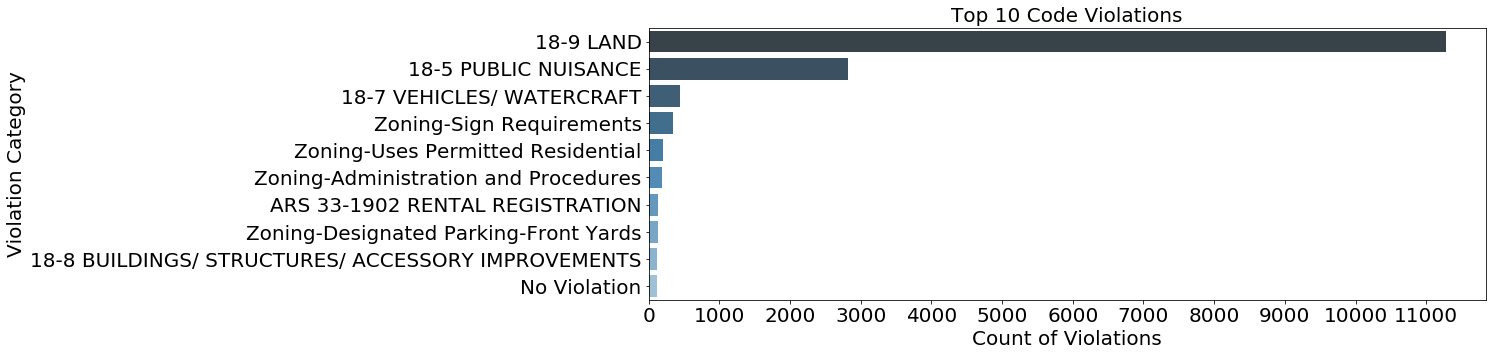

In [6]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = sns.barplot(violation_category.values, violation_category.index, palette="Blues_d")
plt.title('Top 10 Code Violations',fontsize=20)
plt.ylabel('Violation Category',fontsize=20)
plt.xlabel('Count of Violations',fontsize=20)
plt.tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

In [7]:
# which specific sub-categories within 'Land' have the most violations?
land_violations = code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['18-9 LAND'] \
    .dropna() \
    .sort_values(ascending=False)

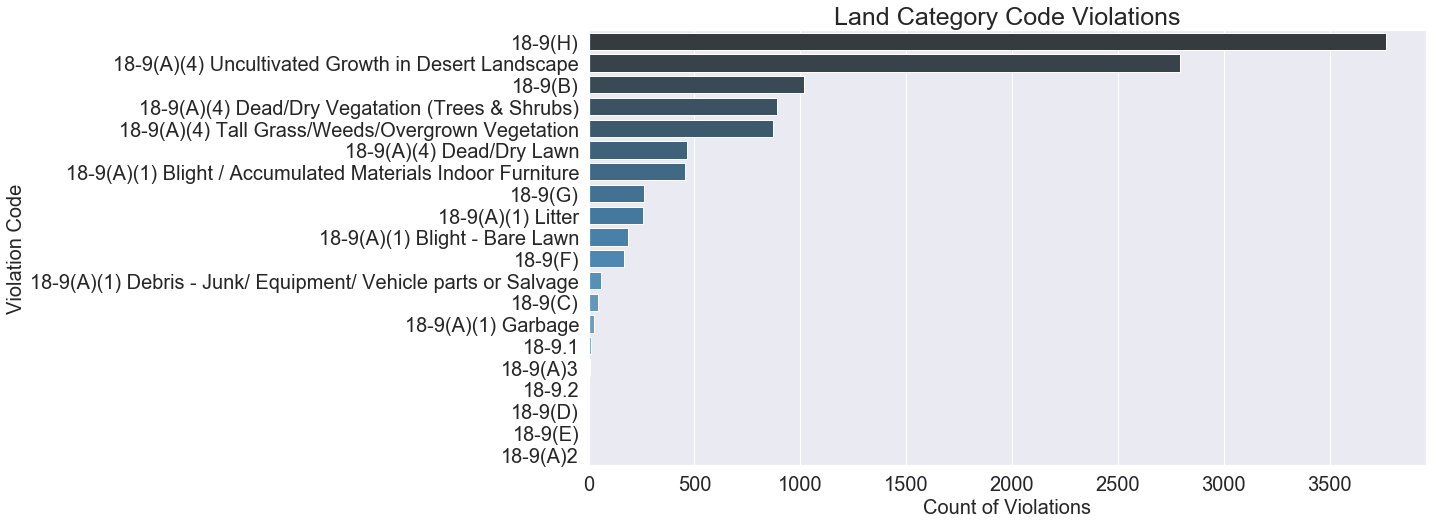

In [46]:
sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(land_violations.values, land_violations.index, palette="Blues_d")
plt.title('Land Category Code Violations',fontsize=25)
plt.ylabel('Violation Code',fontsize=20)
plt.xlabel('Count of Violations',fontsize=20)
plt.tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

## Which code violations have the highest mean days before they are closed?

In [20]:
open_close_dif = code_violations.groupby('_ViolationCategory_')['Open_Close_Dif_Days'] \
    .mean() \
    .astype(int) \
    .sort_values(ascending=False)

open_close_dif.head(15)

_ViolationCategory_
Zoning-Native Plant Program                                                                             138
Zoning-Article I ADMINISTRATION AND PROCEDURES: Sec. 1.400 CONDITIONAL USE PERMITS.                     116
Zoning-Uses Permitted Commercial                                                                        104
Zoning-Article VII General Provisions: Sec. 7.200 Additional Area Regulations                           101
18-110 UNIFORM HOUSING CODE SECTION 1001.8 FAULTY WEATHER PROTECTION                                     96
OTHER                                                                                                    95
Zoning-Development Review Board Approval                                                                 93
Zoning-Article V District Regulations: Sec. 5.100 R1-43 Single-Family Residential District               89
Development Review Board                                                                                 86
Zoning-A

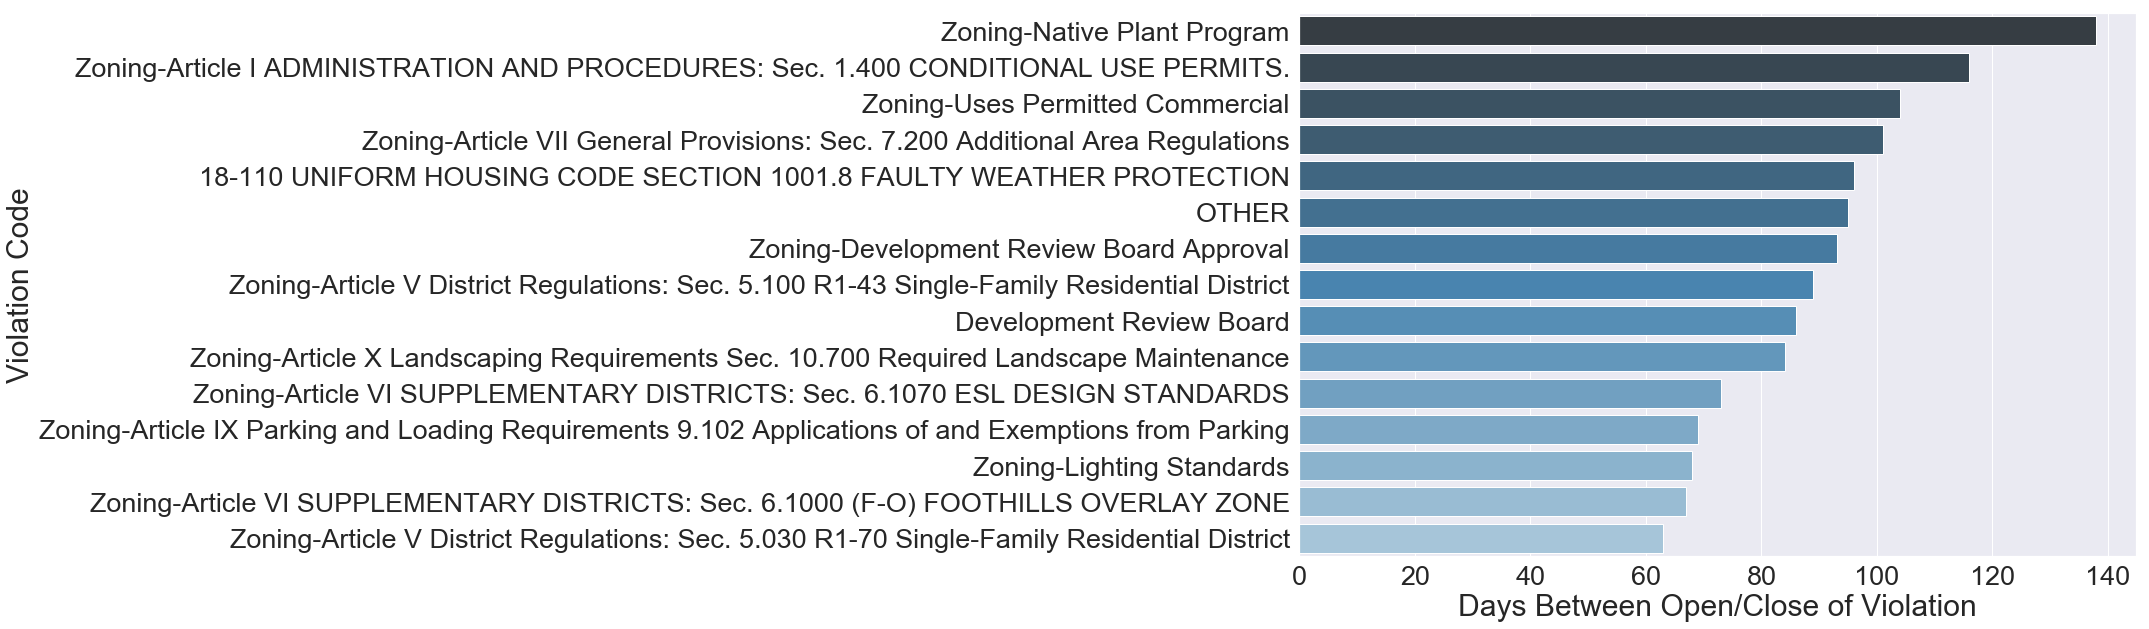

In [45]:
sns.set(rc={'figure.figsize':(15,10)})

sns.barplot(open_close_dif.head(15), open_close_dif.head(15).index, palette="Blues_d")
plt.ylabel('Violation Code',fontsize=30)
plt.xlabel('Days Between Open/Close of Violation',fontsize=30)
plt.tick_params(labelsize=27)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

## Which code violations have the lowest mean days before they are closed?

In [41]:
open_close_dif.tail(20)

_ViolationCategory_
Zoning-Article IX Parking and Loading Requirements: Sec. 9.105 Mobility impaired accessible spaces    28
Zoning-Property Development Standards R1-10                                                           27
Zoning-Designated Parking-Front Yards                                                                 26
Zoning-Outdoor Lighting                                                                               24
17-  ON STREET VEHICLE PARKING                                                                        21
18-110 UNIFORM HOUSING CODE SECTION 1001.11 HAZARDOUS OR INSANITARY PREMISES                          19
18-9 LAND                                                                                             17
18-5 PUBLIC NUISANCE                                                                                  17
18-6 LITTER CONTROL                                                                                   17
Required Parking Locations         

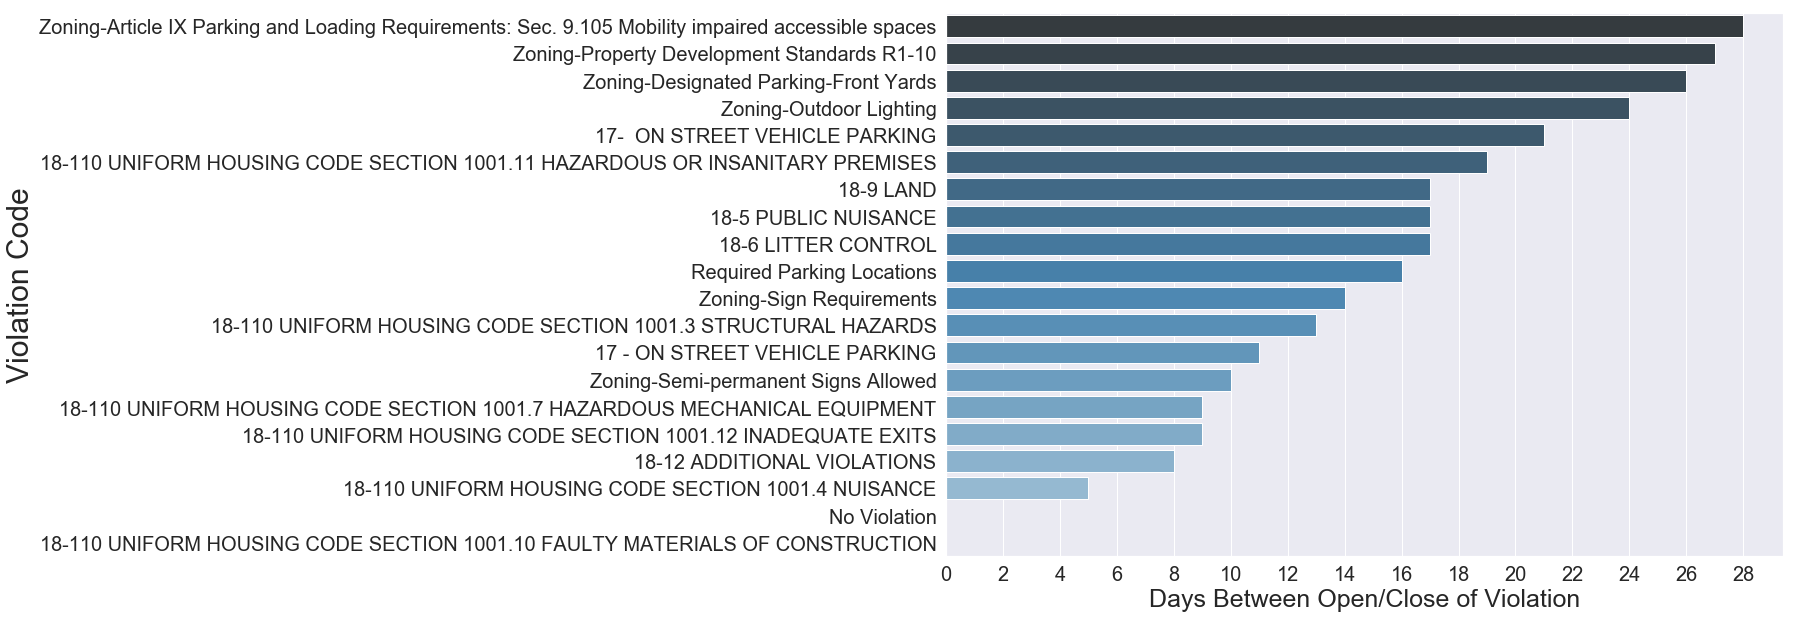

In [47]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.barplot(open_close_dif.tail(20).values, open_close_dif.tail(20).index, palette="Blues_d")
plt.ylabel('Violation Code',fontsize=30)
plt.xlabel('Days Between Open/Close of Violation',fontsize=25)
plt.tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

In [119]:
code_violations.head()

,_ViolationID_,_ComplaintID_,_DateComplaintReceived_,_DateComplaintClosed_,_ComplaintStatus_,_ViolationCategory_,_ViolationCode_,_StreetNumber_,_StreetDirection_,_StreetName_,_StreetType_,_SuiteApt_,_UnitNumber_,_ZipCode_,_ParcelCode_,_Subdivision_,_LotNumber_,_Latitude_,_Longitude_,Open_Close_Dif,Open_Close_Dif_Days,Day_of_Year_Opened,Day_of_Year_Closed,Month_Opened,Month_Closed
0,345175,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Administration and Procedures,1.1101,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
1,345176,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Article VI SUPPLEMENTARY DISTRICTS: Sec...,6.1060.A.1,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
2,345177,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Native Plant Program,7.501.1.b,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0,21,201,1,7
3,355908,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,3.100,8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0,223,99,8,4
4,356293,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,5.012(A)(R1-190),8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0,223,99,8,4


In [87]:
opened = code_violations.groupby('Day_of_Year_Opened')['Day_of_Year_Opened'].count().to_frame()
closed = code_violations.groupby('Day_of_Year_Closed')['Day_of_Year_Closed'].count().to_frame()

closed.head()

,Day_of_Year_Closed
Day_of_Year_Closed,
2,24
3,65
4,18
7,50
8,44


In [106]:
open_close_day_of_year = opened.merge(closed, left_index=True, right_index=True)

open_close_day_of_year.index.rename('Day_of_Year', inplace=True)
open_close_day_of_year.reset_index(inplace=True)
open_close_day_of_year.head()

,Day_of_Year,Day_of_Year_Opened,Day_of_Year_Closed
0,2,30,24
1,3,41,65
2,4,34,18
3,7,24,50
4,8,36,44


In [110]:
pd.melt(open_close_day_of_year, id_vars='Day_of_Year').head()

,Day_of_Year,variable,value
0,2,Day_of_Year_Opened,30
1,3,Day_of_Year_Opened,41
2,4,Day_of_Year_Opened,34
3,7,Day_of_Year_Opened,24
4,8,Day_of_Year_Opened,36


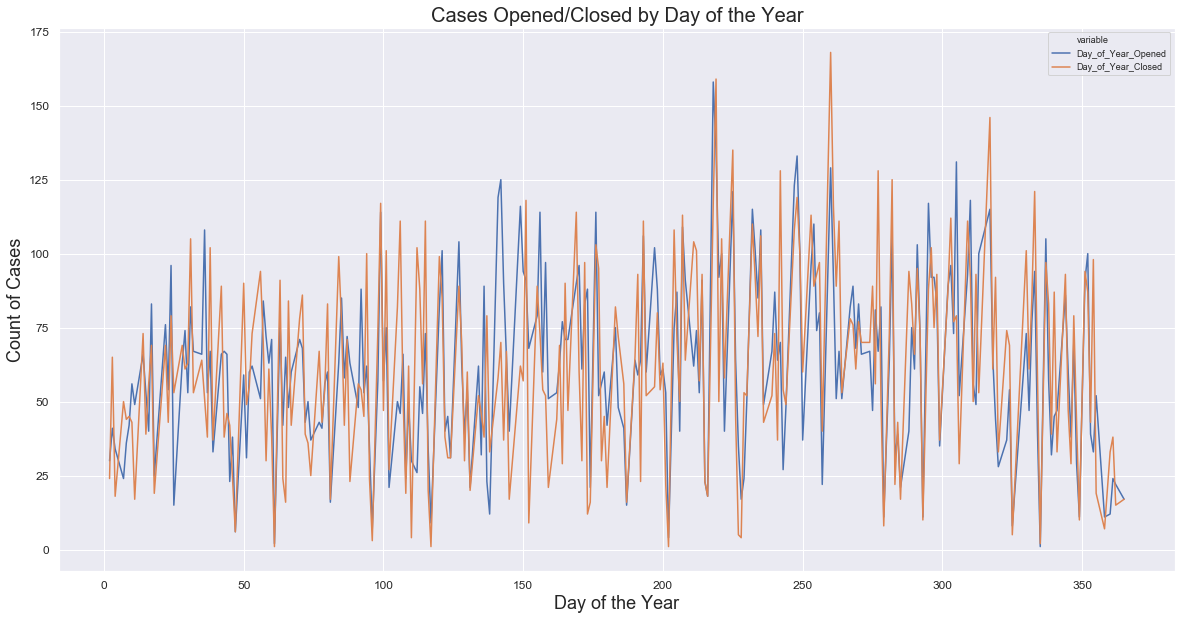

In [116]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,0], \
             y=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,2], \
             hue=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,1], \
             data=pd.melt(open_close_day_of_year, id_vars='Day_of_Year'))

plt.title("Cases Opened/Closed by Day of the Year",fontsize=20)
plt.xlabel("Day of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=9)

# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(25))

In [123]:
code_violations.loc[:,'Month_Opened'].head()

0    1
1    1
2    1
3    8
4    8
Name: Month_Opened, dtype: int64

In [131]:
opened_month = code_violations.groupby('Month_Opened')['Month_Opened'].count().to_frame()
closed_month = code_violations.groupby('Month_Closed')['Month_Closed'].count().to_frame()


open_close_month_of_year = opened_month.merge(closed_month, left_index=True, right_index=True)
open_close_month_of_year.index.rename('Month_of_Year', inplace=True)

open_close_month_of_year.reset_index(inplace=True)
open_close_month_of_year.head()

pd.melt(open_close_month_of_year, id_vars='Month_of_Year').head()

,Month_of_Year,variable,value
0,1,Month_Opened,1100
1,2,Month_Opened,1147
2,3,Month_Opened,1205
3,4,Month_Opened,1214
4,5,Month_Opened,1456


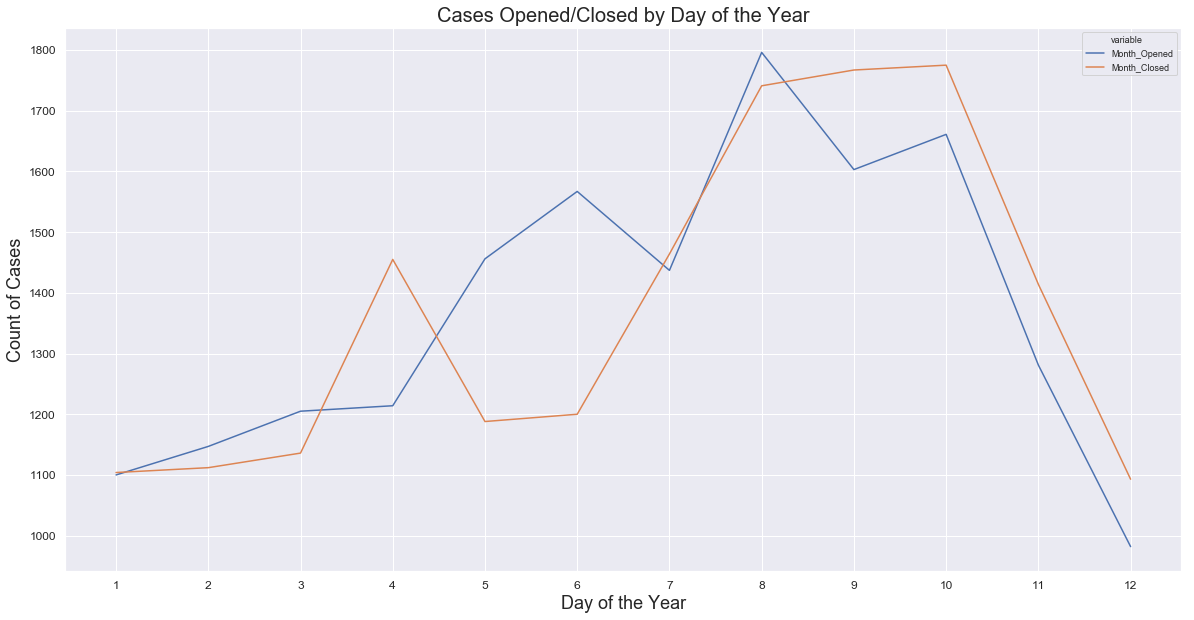

In [139]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.lineplot(x=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,0], \
             y=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,2], \
             hue=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,1], \
             data=pd.melt(open_close_month_of_year, id_vars='Month_of_Year'))

plt.title("Cases Opened/Closed by Month of the Year",fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=9)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())